<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span></li></ul></div>

#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

## Подготовка

In [1]:
import pandas as pd 
import numpy as np 
import seaborn as sn 
import matplotlib.pyplot as plt 

from statsmodels.tsa.seasonal import seasonal_decompose

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, TimeSeriesSplit, GridSearchCV

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor

RND = 12345

import warnings
warnings.filterwarnings('ignore')


In [2]:
df = pd.read_csv('/datasets/taxi.csv', parse_dates=[0])

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26496 entries, 0 to 26495
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   datetime    26496 non-null  datetime64[ns]
 1   num_orders  26496 non-null  int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 414.1 KB


In [4]:
df.head()

,datetime,num_orders
0,2018-03-01 00:00:00,9
1,2018-03-01 00:10:00,14
2,2018-03-01 00:20:00,28
3,2018-03-01 00:30:00,20
4,2018-03-01 00:40:00,32


In [5]:
df.isna().sum()

datetime      0
num_orders    0
dtype: int64

В датасете 2 столбца, 26496 наблюдений. Признаки: datetime — состоит из даты и времени, num_orders — количество заказов (целевой признак). Типы данных в порядке.

Проверим хронологический порядок даты и времени и выполним ресемплирование по одному часу.

In [6]:
df = df.set_index('datetime')
df = df.sort_index() 
df.index.is_monotonic

True

In [7]:
df = df.resample('1H').sum()
df

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43
...,...
2018-08-31 19:00:00,136
2018-08-31 20:00:00,154
2018-08-31 21:00:00,159


**Вывод 1.** Данные - заказы такси с 2018-03-01 00:00:00 по 2018-08-31 23:50:00. Данные  загружены и подготовлены. Пропусков нет. Дубликаты искать нет очевидного смысла. Данные расположены в хронологическом порядке и ресемплированы по одному часу.

## Анализ

Оценим значения.

In [8]:
df.describe()

,num_orders
count,4416.000000
mean,84.422781
std,45.023853
min,0.000000
25%,54.000000
50%,78.000000
75%,107.000000
max,462.000000


Аномалий, выбросов не установлено. Пробуем визуализировать данные.

<AxesSubplot:xlabel='datetime'>

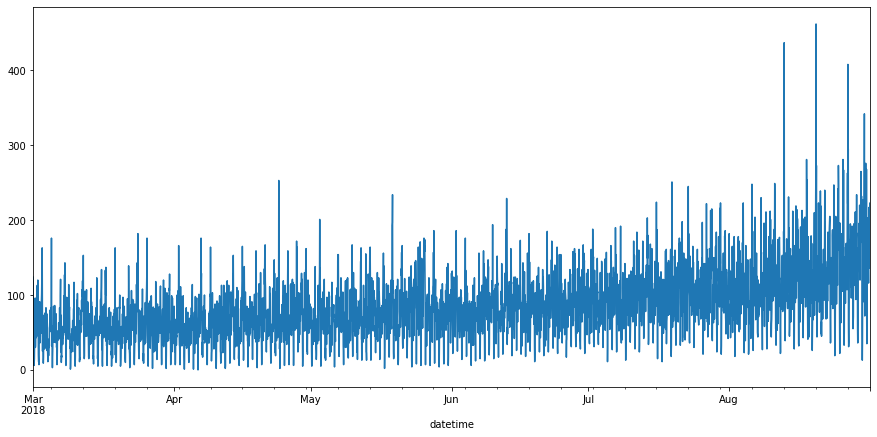

In [9]:
df['num_orders'].plot(figsize=(15,7))

Не информативно. Посмотрим на скользящее среднее и скользящее среднее отклонение.

<AxesSubplot:xlabel='datetime'>

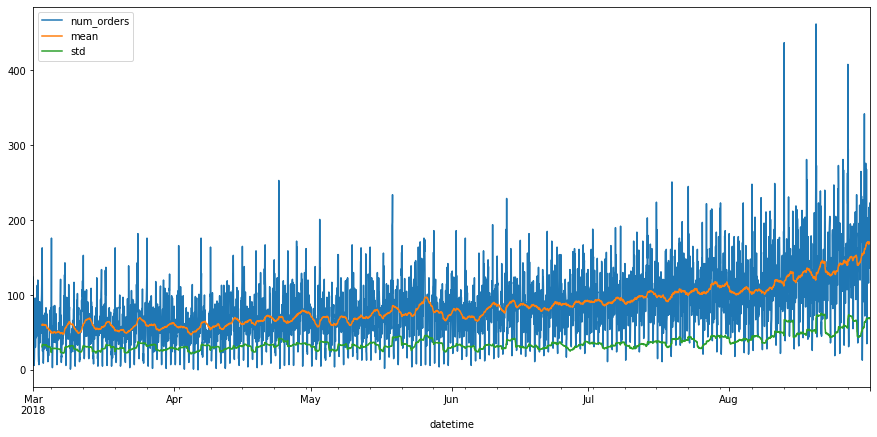

In [10]:
df['mean'] = df['num_orders'].rolling(48).mean()
df['std'] = df['num_orders'].rolling(48).std()
df.plot(figsize=(15,7))

По данным графикам можно сделать вывод, что присутствует некоторый восходящий тренд количества заказов за рассматриваемый период (6 месяцев). Среднее значение и стандартное отклонение со временем увеличиваются - временной ряд нестационарный. 

In [11]:
# код ревьювера
from statsmodels.tsa.stattools import adfuller

ts = df['num_orders']
st_test = adfuller(ts, regression='ctt')

print('Если значение с индексом 1 меньше P-Value, заданное нами (обычно берут 0.05), то ряд стационарный')
if st_test[1] < 0.05:
    print('Наш ряд стационарный')
else:
    print('Ряд нестационарный')




Если значение с индексом 1 меньше P-Value, заданное нами (обычно берут 0.05), то ряд стационарный
Наш ряд стационарный


<AxesSubplot:xlabel='datetime'>

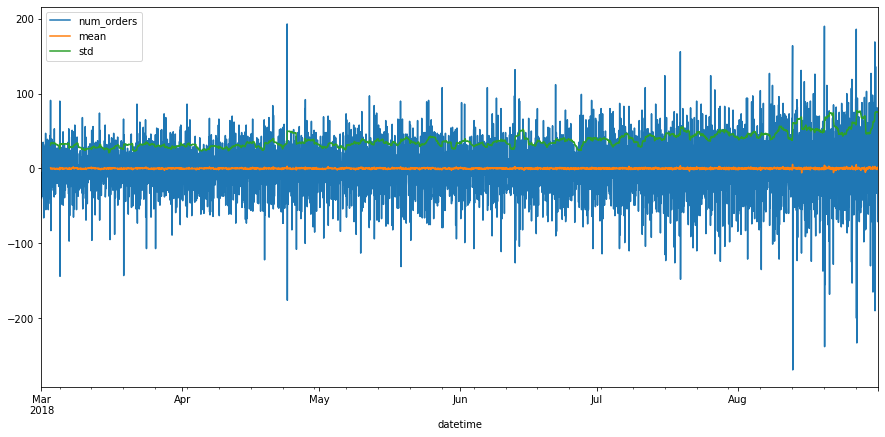

In [12]:
df = df.drop(['mean', 'std'], axis=1)

df_shift = df - df.shift() 
df_shift['mean'] = df_shift['num_orders'].rolling(48).mean()
df_shift['std'] = df_shift['num_orders'].rolling(48).std()

df_shift.plot(figsize=(15,7))

Разложим ряд на тренд, сезонность и остаток.

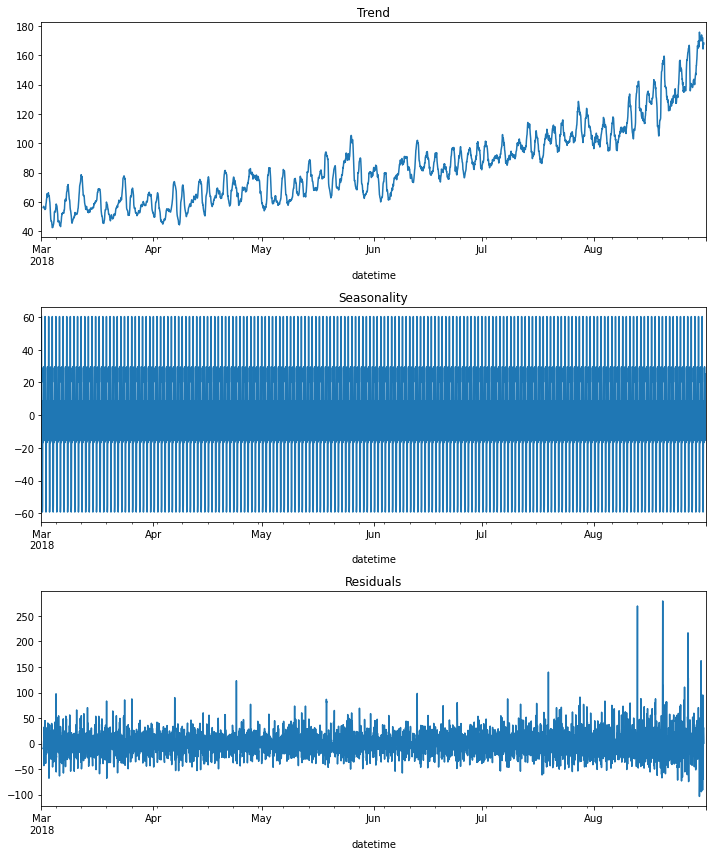

In [13]:
decomposed = seasonal_decompose(df['num_orders']) 

plt.figure(figsize=(10, 12))
plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca()) 
plt.title('Residuals')
plt.tight_layout()

Рассмотрим сезонность подробнее. Внутри дня.

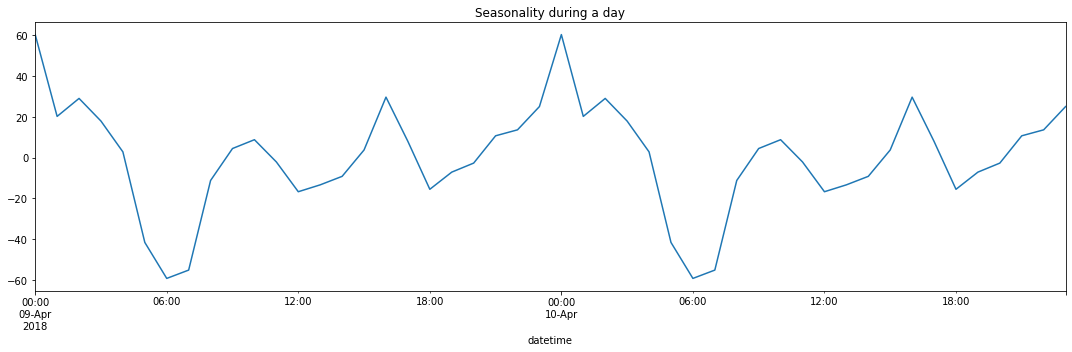

In [14]:
plt.figure(figsize=(15, 5))
decomposed.seasonal['2018-04-09':'2018-04-10'].plot(ax=plt.gca())
plt.title('Seasonality during a day')
plt.tight_layout()

Реже заказывают такси в 6 утра, а пик заказов приходится на полночь. Так как мы рассматриваем заказы такси в аэропорту, возможно подобная тенденция связана с работой общественного транспорта. Например, аэроэкспресс работает с 6.00 утра до 23.40 ночи.



**Вывод 2.** Мы провели анализ данных. Установлено, что присутствует определенный восходящий тренд по количеству заказов в течение полугода. Оценили количество заказов такси внутри дня и установили, что максимум их приходится на полночь, а минимум на 6.00 утра. 

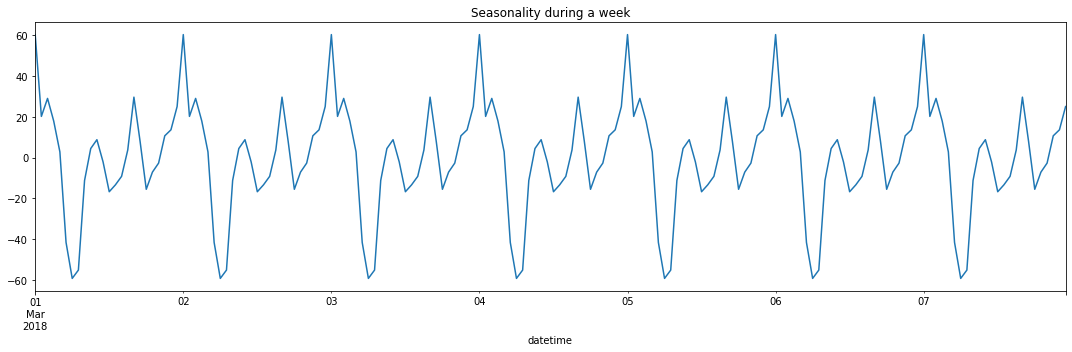

In [15]:
plt.figure(figsize=(15, 5))
decomposed.seasonal['2018-03-01':'2018-03-07'].plot(ax=plt.gca())
plt.title('Seasonality during a week')
plt.tight_layout()

Все довольно ровно с недельной сезонностью.

## Обучение

Создадим новые признаки - месяц, день, день недели, час, лаги(отставания), скользящее среднее.

In [16]:
def make_features(df, max_lag, rolling_mean_size):
    #df['month'] = df.index.month
    df['day'] = df.index.day
    df['dayofweek'] = df.index.dayofweek
    df['hour'] = df.index.hour
    
    for lag in range(1, max_lag + 1):
        df['lag_{}'.format(lag)] = df['num_orders'].shift(lag)

    df['rolling_mean'] = df['num_orders'].shift().rolling(rolling_mean_size).mean()
    df.dropna(inplace=True)

In [17]:
make_features(df, 24, 7)
df

,num_orders,day,dayofweek,hour,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,...,lag_16,lag_17,lag_18,lag_19,lag_20,lag_21,lag_22,lag_23,lag_24,rolling_mean
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-02 00:00:00,90,2,4,0,58.0,113.0,66.0,61.0,45.0,73.0,...,34.0,15.0,12.0,6.0,43.0,66.0,71.0,85.0,124.0,65.714286
2018-03-02 01:00:00,120,2,4,1,90.0,58.0,113.0,66.0,61.0,45.0,...,69.0,34.0,15.0,12.0,6.0,43.0,66.0,71.0,85.0,72.285714
2018-03-02 02:00:00,75,2,4,2,120.0,90.0,58.0,113.0,66.0,61.0,...,64.0,69.0,34.0,15.0,12.0,6.0,43.0,66.0,71.0,79.000000
2018-03-02 03:00:00,64,2,4,3,75.0,120.0,90.0,58.0,113.0,66.0,...,96.0,64.0,69.0,34.0,15.0,12.0,6.0,43.0,66.0,83.285714
2018-03-02 04:00:00,20,2,4,4,64.0,75.0,120.0,90.0,58.0,113.0,...,30.0,96.0,64.0,69.0,34.0,15.0,12.0,6.0,43.0,83.714286
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-08-31 19:00:00,136,31,4,19,207.0,217.0,197.0,116.0,133.0,166.0,...,99.0,230.0,194.0,276.0,246.0,158.0,198.0,142.0,72.0,167.428571
2018-08-31 20:00:00,154,31,4,20,136.0,207.0,217.0,197.0,116.0,133.0,...,268.0,99.0,230.0,194.0,276.0,246.0,158.0,198.0,142.0,167.428571
2018-08-31 21:00:00,159,31,4,21,154.0,136.0,207.0,217.0,197.0,116.0,...,78.0,268.0,99.0,230.0,194.0,276.0,246.0,158.0,198.0,165.714286


Разделим выборку, как указано в задаче.

In [19]:
train, test = train_test_split(df, shuffle=False, test_size=0.1)
train = train.dropna()
test = test.dropna()
features_train = train.drop(['num_orders'], axis=1)
target_train = train['num_orders']
features_test = test.drop(['num_orders'], axis=1)
target_test = test['num_orders']

Проверим.

In [20]:
train.shape, train.index.min(), train.index.max()

((3952, 29),
 Timestamp('2018-03-02 00:00:00', freq='H'),
 Timestamp('2018-08-13 15:00:00', freq='H'))

In [21]:
test.shape, test.index.min(), test.index.max()

((440, 29),
 Timestamp('2018-08-13 16:00:00', freq='H'),
 Timestamp('2018-08-31 23:00:00', freq='H'))

In [22]:
features_train.shape, features_train.index.min(), features_train.index.max()

((3952, 28),
 Timestamp('2018-03-02 00:00:00', freq='H'),
 Timestamp('2018-08-13 15:00:00', freq='H'))

In [23]:
features_test.shape, features_test.index.min(), features_test.index.max()

((440, 28),
 Timestamp('2018-08-13 16:00:00', freq='H'),
 Timestamp('2018-08-31 23:00:00', freq='H'))

Напишем функцию для обучения, предсказания, тестирования моделей и расчета RMSE.

In [24]:
def train_and_show_rmse(model, title):
    model = model
    model.fit(features_train, target_train)
    train_pred = model.predict(features_train)
    test_pred = model.predict(features_test)
    print(title)
    print("RMSE обучающей выборки:", mean_squared_error(target_train, train_pred)**0.5)
    print("RMSE тестовой выборки: ", mean_squared_error(target_test, test_pred)**0.5)

## Тестирование

Модель LGBMRegressor.

**Подберем гиперпараметры.**

In [28]:
tscv = TimeSeriesSplit(n_splits=5)

Для LinearRegression.

In [29]:
lr_params = {'fit_intercept':[True,False], \
             'normalize':[True,False], 'copy_X':[True, False]}

lr_grid = GridSearchCV(LinearRegression(), param_grid = lr_params, \
                       refit=False, scoring='neg_mean_squared_error', cv=tscv)
lr_grid.fit(features_train, target_train)

lr_best_params = lr_grid.best_params_
lr_m = LinearRegression(**lr_best_params)
lr_m.fit(features_train, target_train)
lr_rmse = (-lr_grid.best_score_) ** 0.5 

#lr_test_pred = lr_m.predict(features_test)

print('Лучшие гиперпараметры: ', lr_best_params)
print("RMSE:", lr_rmse)

Лучшие гиперпараметры:  {'copy_X': True, 'fit_intercept': False, 'normalize': True}
RMSE: 27.352473482433886


Для RandomForestRegressor.

In [30]:
rf_params = {
        'n_estimators' : range(50, 101, 10),
        'max_depth' : range(5, 15, 2),
        'verbose' : [0],
        'random_state' : [RND] 
        }


rf_grid = GridSearchCV(RandomForestRegressor(), param_grid = rf_params, \
                       refit=False, scoring='neg_mean_squared_error', cv=tscv)
rf_grid.fit(features_train, target_train)

rf_best_params = rf_grid.best_params_
rf_m = RandomForestRegressor(**rf_best_params)
rf_m.fit(features_train, target_train)
rf_rmse = (-rf_grid.best_score_)**0.5    
#rf_test_pred = rf_m.predict(features_test)

print('Лучшие гиперпараметры: ', rf_best_params)
print("RMSE :", rf_rmse)

Лучшие гиперпараметры:  {'max_depth': 13, 'n_estimators': 100, 'random_state': 12345, 'verbose': 0}
RMSE : 25.49815263697898


Для LGBMRegressor.

In [ ]:
lgb_params = {
        'n_estimators' : range(50, 101, 10),
        'max_depth' : range(5, 15, 2),
        'verbose' : [0],
        'random_state' : [RND] 
        }

lgb_grid = GridSearchCV(LGBMRegressor(), param_grid = lgb_params, \
                        refit=False, scoring='neg_mean_squared_error', cv=tscv)

lgb_grid.fit(features_train, target_train)

lgb_best_params = lgb_grid.best_params_
lgb_m = LGBMRegressor(**lgb_best_params)
lgb_m.fit(features_train, target_train)
lgb_rmse = (-rf_grid.best_score_)**0.5     
#lgb_test_pred = lgb_m.predict(features_test)

print('Лучшие гиперпараметры: ', lgb_best_params)
print("RMSE :", lgb_rmse)

Лучшая метрика RMSE у модели LGBMRegressor. Проверим ее на тестовой выборке.

In [ ]:
lgb_m = LGBMRegressor(**lgb_best_params)
lgb.fit(features_train, target_train)
lgb_test_pred = lgb_m.predict(features_test)

print("RMSE тестовой выборки: ", mean_squared_error(target_test, lgb_test_pred)**0.5)

**Вывод 3.** В ходе выполнения проекта были загружены, подготовлены и проанализированы исторические данные о заказах такси в аэропортах от компании «Чётенькое такси». Для сравнения в проекте были задействованы модели LinearRegression, RandomForestRegressor и LGBMRegressor. На тестовой выборке с лучшими гиперпараметрами наименьшую RMSE = 40.8570 показала модель LGBMRegressor.
Значение метрики RMSE на тестовой выборке по условиям задания должно быть не больше 48, а это значит, что данную модель можно рекомендовать для прогнозирования количества заказов такси на следующий час.